In [ ]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import time

## Generating a latent space representation
To make it more "understandable" where material is placed we generate a slowly varying landscape by interpolation of a low resolution map.

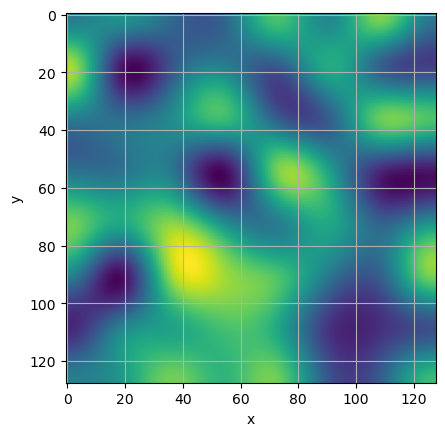

In [ ]:
features = 8
zoom = 16
heatmap = np.random.random((features,features))-0.5
large_heatmap = scipy.ndimage.zoom(heatmap, zoom)
plt.imshow(large_heatmap)
plt.xlabel("x")
plt.ylabel("y")
plt.grid()

## Generating the brush

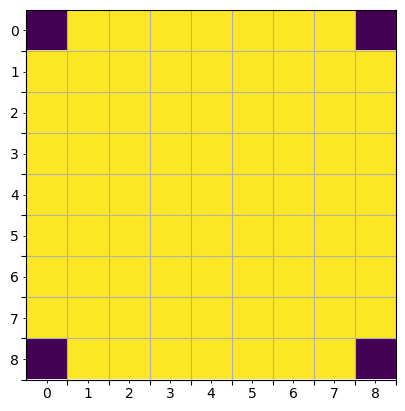

In [ ]:
kernel_size=9
brush = np.ones((kernel_size, kernel_size))
brush[0,0] = 0
brush[0,-1] = 0
brush[-1,0] = 0
brush[-1,-1] = 0

nx, ny = brush.shape

plt.imshow(brush)
ax = plt.gca()
ax.set_yticks(np.arange(nx)+0.5)
ax.set_yticklabels(["" for i in range(nx)])
ax.set_xticks(np.arange(ny)+0.5)
ax.set_xticklabels(["" for i in range(ny)])
ax.set_yticks(np.arange(nx), minor=True)
ax.set_yticklabels([f"{i}" for i in range(nx)], minor=True)
ax.set_xticks(np.arange(ny), minor=True)
ax.set_xticklabels([f"{i}" for i in range(ny)], minor=True)
plt.grid()

## Running the Generator

/var/folders/s4/d8sxz9nj0j57pj58g4dc54300000gn/T/ipykernel_19317/3885273807.py:4: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  dil = scipy.ndimage.morphology.binary_dilation(img, brush)


0: valid
1: valid
2: resolving
3: free
4: valid
5: free
6: valid
7: valid
8: valid
9: free
10: valid
11: valid
12: free
13: resolving
14: free
15: valid
16: valid
17: valid
18: free
19: valid
20: valid
21: valid
22: free
23: valid
24: valid
25: free
26: valid
27: free
28: valid
29: valid
30: free
31: valid
32: valid
33: valid
34: valid
35: valid
36: resolving
37: free
38: valid
39: valid
40: resolving
41: free
42: valid
43: free
44: resolving
45: free
46: valid
47: resolving
48: free
49: resolving
50: free
51: valid
52: free
53: valid
54: free
55: valid
56: resolving
57: free
58: valid
59: free
60: valid
61: free
62: resolving
63: free
64: resolving
65: free
66: valid
67: valid
68: free
69: valid
70: free
71: valid
72: free
73: valid
74: free
75: valid
76: free
77: valid
78: resolving
79: free
80: valid
81: valid
82: valid
83: free
84: valid
85: free
86: valid
87: free
88: valid
89: valid
90: free
91: valid
92: valid
93: resolving
94: free
95: valid
96: valid
97: free
98: valid
99: fre

<matplotlib.image.AxesImage>

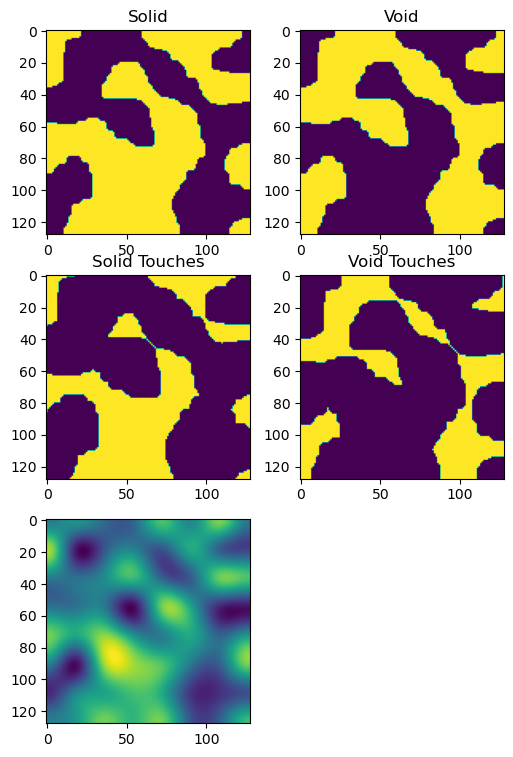

In [ ]:
def dilate(img, brush):
    global time_dilate
    time_dilate -= time.process_time() 
    dil = scipy.ndimage.morphology.binary_dilation(img, brush)
    time_dilate += time.process_time() 
    return dil

def existing_pixels(touches, brush):
    return dilate(touches, brush)

def impossible_touches(existing_other, brush):
    return dilate(existing_other, brush)

def valid_touches(impossible, touches):
    return np.logical_and(np.logical_not(impossible), np.logical_not(touches))

def possible_pixels(valid, touches, brush):
    possible_touches = np.logical_or(touches, valid)
    return dilate(possible_touches, brush)

def required_pixels(existing, possible_other):
    return np.logical_and(np.logical_not(existing), np.logical_not(possible_other))

def resolving_touches(required, valid, brush):
    return np.logical_and(dilate(required, brush), valid)

def free_touches(possible_other, existing_other, valid, brush):
    dilated = dilate(np.logical_or(possible_other, existing_other), brush)
    return np.logical_and(np.logical_not(dilated), valid)

def select_single(s_valid, v_valid, s_suggest, v_suggest, brush, t_s, t_v):
    s_weights = scipy.ndimage.convolve(s_suggest, brush)
    v_weights = -scipy.ndimage.convolve(v_suggest, brush)

    s_weights[np.logical_not(s_valid)] = np.nan
    v_weights[np.logical_not(v_valid)] = np.nan

    max_s = max_v = -np.inf
    if s_valid.any():
        max_pos_s = np.nanargmax(s_weights)
        max_s = s_weights.flat[max_pos_s]
    
    if v_valid.any():
        max_pos_v = np.nanargmax(v_weights)
        max_v = v_weights.flat[max_pos_v]

    if  max_s > max_v:
        t_s.flat[max_pos_s] = True
    else:
        t_v.flat[max_pos_v] = True

    return t_s, t_v

s_suggest = large_heatmap.copy()
v_suggest = large_heatmap.copy()
t_s = np.zeros_like(s_suggest).astype(bool)
t_v = t_s.copy()

time_update = 0
time_select = 0 
time_dilate = 0
time_existing = 0
time_impossible = 0
time_valid = 0
time_possible = 0
time_required = 0
time_resolving = 0
time_free = 0

debug = True
def log(*args):
  if debug:
    print(*args)

for i in range(10000):
    time_update -= time.process_time() 

    time_existing -= time.process_time() 
    p_s_existing = existing_pixels(t_s, brush)
    p_v_existing = existing_pixels(t_v, brush)
    time_existing += time.process_time() 

    s_suggest[p_s_existing] = 0
    v_suggest[p_v_existing] = 0

    time_impossible -= time.process_time() 
    t_s_impossible = impossible_touches(p_v_existing, brush)
    t_v_impossible = impossible_touches(p_s_existing, brush)
    time_impossible += time.process_time() 

    time_valid -= time.process_time() 
    t_s_valid = valid_touches(t_s_impossible, t_s)
    t_v_valid = valid_touches(t_v_impossible, t_v)
    time_valid += time.process_time() 

    time_possible -= time.process_time() 
    p_s_possible = possible_pixels(t_s_valid,t_s,brush)
    p_v_possible = possible_pixels(t_v_valid,t_v,brush)
    time_possible += time.process_time() 

    time_required -= time.process_time() 
    p_s_required = required_pixels(p_s_existing, p_v_possible)
    p_v_required = required_pixels(p_v_existing, p_s_possible)
    time_required += time.process_time() 

    time_resolving -= time.process_time() 
    t_s_resolving = resolving_touches(p_s_required, t_s_valid, brush)
    t_v_resolving = resolving_touches(p_v_required, t_v_valid, brush)
    time_resolving += time.process_time() 

    time_free -= time.process_time() 
    t_s_free = free_touches(p_v_possible, p_v_existing, t_s_valid, brush)
    t_v_free = free_touches(p_s_possible, p_s_existing, t_v_valid, brush)
    time_free += time.process_time() 

    time_update += time.process_time() 
    time_select -= time.process_time() 

    if t_s_free.any() or t_v_free.any():
        log(f"{i}: free")
        t_s = np.logical_or(t_s, t_s_free)
        t_v = np.logical_or(t_v, t_v_free)
    elif t_s_resolving.any() or t_v_resolving.any():
        log(f"{i}: resolving")
        t_s, t_v = select_single(t_s_resolving, t_v_resolving, s_suggest, v_suggest, brush, t_s, t_v)
    elif t_s_valid.any() or t_v_valid.any():
        log(f"{i}: valid")
        t_s, t_v = select_single(t_s_valid, t_v_valid, s_suggest, v_suggest, brush, t_s, t_v)
    else:
        print("finished")
        time_select += time.process_time() 
        break

    time_select += time.process_time() 


plt.figure(figsize = (6,9))
plt.subplot(321)
plt.title("Solid")
plt.imshow(p_s_existing)
plt.subplot(322)
plt.title("Void")
plt.imshow(p_v_existing)
plt.subplot(323)
plt.title("Solid Touches")
plt.imshow(t_s)
plt.subplot(324)
plt.title("Void Touches")
plt.imshow(t_v)
plt.subplot(325)
plt.imshow(large_heatmap)

In [ ]:
print(f"""
{time_update = }
{time_select = }
{time_dilate = }
{time_existing = }
{time_impossible = }
{time_valid = }
{time_possible = }
{time_required = }
{time_resolving = }
{time_free = }""")


time_update = 6.343073000000096
time_select = 0.7340389999998678
time_dilate = 6.277771999999722
time_existing = 1.4711729999999221
time_impossible = 1.202355999999888
time_valid = 0.007606000000166091
time_possible = 0.9830029999996839
time_required = 0.00692399999996951
time_resolving = 1.9217890000001603
time_free = 0.7302579999999352
